# Импортируем библиотеки

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import string
import re
import zipfile
import glob
import nltk
from pymystem3 import Mystem
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer as snow 
import pymorphy2
from functools import lru_cache
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# 1.1 Парсинг данных

Разархивируем zip через код

In [2]:
fantasy_zip = zipfile.ZipFile('Data.zip') # Открыть zip файл
fantasy_zip.extractall() # Разархировать в папку
fantasy_zip.close() # Закрыть файл

Получим список всех json'ов, которые находятся внутри папки архива

In [3]:
list_json = glob.glob("data/*.json") # Получим список json файлов
list_json

['data\\00c2bfc7-57db-496e-9d5c-d62f8d8119e3.json',
 'data\\00e58afe-3ef5-42a6-92f3-8ee7abf868e1.json',
 'data\\0104b39c-7aa4-45cd-8d28-b05dc6bafdf2.json',
 'data\\01472aab-d8c2-43aa-b510-e259d58cd9a4.json',
 'data\\017a0674-613b-428d-8e3a-7dcf86b72edb.json',
 'data\\0203e66f-4fda-4f79-b454-ef353914810b.json',
 'data\\02343952-78b0-4e51-9d0f-ccfc6afd1eff.json',
 'data\\0266c1a8-c9e9-4fe5-b271-85269772e88e.json',
 'data\\034254a6-d1ba-4619-b7a8-4b3f2098f37f.json',
 'data\\034c6cd6-4e94-4be4-96a0-9e077b2ed089.json',
 'data\\03a621b9-c2e8-4a8a-a992-e6353ebd8ddc.json',
 'data\\03b5cca3-309c-4377-b481-cbd9909b2644.json',
 'data\\0565155c-7303-4dd0-a632-22b02d6869fe.json']

Посмотрим на струкутру json

In [4]:
with open(list_json[5], "r", encoding='utf-8') as f: # Чтение файлов
    text = json.load(f)
text

[{'id': '52400834',
  'text': "The Western Province Ice Hockey Association, more commonly known as WP Ice Hockey, is a non-profit organization and member branch of South African Ice Hockey Federation in charge of governing ice hockey at all levels in Western Cape. It comprises 3 ice hockey teams, 110 players, 10 officials. ==Executive Committee== * Jason Cerff - President * Salama Khan - Vice President * Tracy Cerff - General Secretary * Nasir Khan - Treasurer * Sharief Kamish - Junior Development * Steven Johnson - Senior Development * Dominic Young - Players Rep * Gillian Swart - Women in Sport * Marc Giot - Head Coach * Jonathan Burger - Referee-in-Chief ==Leagues== *Western Province Ice Hockey U12 League - Under 12's *Western Province Ice Hockey U16 League - Under 16's *Western Province Ice Hockey U20 League - Under 20's *Western Province Ice Hockey Premier League - Senior ==Teams== * Cape Town Kings * Cape Town Penguins * Cape Town Storm * Cape Town Griffins (Ladies Team) == Refer

In [5]:
with open(list_json[7], "r", encoding='utf-8') as f: # Чтение файлов
    text = json.load(f)
text

[{'id': '58298929',
  'text': 'GTel Zimbabwe is a Zimbabwean owned company that develops and manufactures ICT products and services. It is the first locally owned mobile phone device manufacture in Zimbabwe. In 2014, GTel launched the SL 5.5 which became the 2nd slimmest mobile phone handset in the world behind the Asian Oppo that year. ==History== GTel Zimbabwe was founded in October 2009 as a franchise of G-Tide Mobile International. It re-branded to GTel in July 2011. GTel Zimbabwe was founded by Chamunorwa Shumba and Cheryl Shumba. GTel is headquartered in Harare and Shumba is the founding Chief Executive Officer. As of 2015, GTel had one million mobile phone users in Zimbabwe. In 2015, the company expanded its operations to Kenya. The company released three new phone models in 2018, including the X7 that has wireless charging. ==References== ==External links== * Category:Telecommunications companies of Zimbabwe Category:Mobile phone manufacturers ',
  'title': 'GTel Zimbabwe'},
 {

Структура json'ов слудующая<br>
id - идентификатор<br>
text - текст<br>
title - заголовок<br>
С помощью цикла пройдёмся по всем файлам и соеденим их в единый датафрейм

# 1.2 Формирование струкутры данных

In [6]:
df = pd.DataFrame() # Датафрейм со всеми данными
for json_text in tqdm(list_json):
    with open(json_text, "r", encoding='utf-8') as f: # Чтение файлов
        text = json.load(f)
    df = pd.concat([df, pd.DataFrame(text)])

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.02it/s]


In [7]:
df # Посомотрим на получившийся датафрейм

id                                               text  \
0       7751000  M-137 was a state trunkline highway in the US ...   
1       7751001  In sociology, dynamic density refers to the co...   
2       7751042  Bert Robert Shepard (June 20, 1920 – June 16, ...   
3       7751048  Marc Fein (born Marc Alan Fein October 21, 196...   
4       7751062  Ghelamco Arena panorama indoor. The Ghelamco A...   
...         ...                                                ...   
14832  44387200  Crassuncus livingstoni is a moth of the family...   
14833  44387224  Oru Sisu Jananam is a 1982 Indian Malayalam fi...   
14834  44387237  H. D. Poindexter Houses are a set of historic ...   
14835  44387242  Kallimullu is a 1982 Indian Malayalam film dir...   
14836  44387249  *This is a list of transfers in Serbian footba...   

                                                   title  
0                               M-137 (Michigan highway)  
1                                        Dynamic density  
2                                           Bert Shepard  
3                                              Marc Fein  
4                                         Ghelamco Arena  
...                                                  ...  
14832                             Crassuncus livingstoni  
14833                                   Oru Sisu Jananam  
14834                            H. D. Poindexter Houses  
14835                                         Kallimullu  
14836  List of Serbian football transfers winter 2014–15  

[142390 rows x 3 columns]

# 1.3 Предварителньая обработка

In [8]:
df.dtypes # Посмотрим на типы данных

id       object
text     object
title    object
dtype: object

In [9]:
df['id'] = df['id'].astype('int32') # Переведём идентификатор в численный формат
df.dtypes

id        int32
text     object
title    object
dtype: object

In [10]:
%%time
def correct_text(text):
    text = re.sub(r"<[^>]+>", "", str(text), flags=re.S)
    # удаление последовательностей \r и \n
    text = re.sub(r"\r|\n", " ", str(text), flags=re.S)
    # удаление последовательностей \b
    text = re.sub(r"\b", "", str(text), flags=re.S)
    text = re.sub(r" +", " ", str(text), flags=re.S)
    text = re.sub(r"^\d+$", "", str(text), flags=re.S)
    # Убираем знаки препинания
    text = "".join([ch if ch not in string.punctuation else ' ' for ch in text])
    # Убираем числа
    text = ''.join([i if not i.isdigit() else ' ' for i in text])
    # Убираем лишние пробелы
    text = re.sub(r'\s+', ' ', text, flags=re.I) 
    return text if text != '' else None

df['title'] = df['title'].apply(correct_text)
df['text'] = df['text'].apply(correct_text)
df

CPU times: total: 1min 5s
Wall time: 3min 10s


id                                               text  \
0       7751000  M was a state trunkline highway in the US stat...   
1       7751001  In sociology dynamic density refers to the com...   
2       7751042  Bert Robert Shepard June – June was an America...   
3       7751048  Marc Fein born Marc Alan Fein October in Miami...   
4       7751062  Ghelamco Arena panorama indoor The Ghelamco Ar...   
...         ...                                                ...   
14832  44387200  Crassuncus livingstoni is a moth of the family...   
14833  44387224  Oru Sisu Jananam is a Indian Malayalam film di...   
14834  44387237  H D Poindexter Houses are a set of historic ho...   
14835  44387242  Kallimullu is a Indian Malayalam film directed...   
14836  44387249   This is a list of transfers in Serbian footba...   

                                              title  
0                               M Michigan highway   
1                                   Dynamic density  
2                                      Bert Shepard  
3                                         Marc Fein  
4                                    Ghelamco Arena  
...                                             ...  
14832                        Crassuncus livingstoni  
14833                              Oru Sisu Jananam  
14834                         H D Poindexter Houses  
14835                                    Kallimullu  
14836  List of Serbian football transfers winter –   

[142390 rows x 3 columns]

In [11]:
df.isna().sum() / df.shape[0] * 100 # Посмотрим на пропуски

id       0.000000
text     0.000000
title    0.134139
dtype: float64

Можно увидеть, что у некоторых текстов отсутсвует заголовок и таких записей меньше процента, поэтому уберём их

In [12]:
df.dropna(inplace=True)
df.isna().sum() / df.shape[0] * 100 # Посмотрим на пропуски

id       0.0
text     0.0
title    0.0
dtype: float64

Соеденим заголовки и текст в один признак, это поможет лучше классифицировать текс модели

In [13]:
df['original'] = df['title'] + df['text'] # Соеденим текст
df

id                                               text  \
0       7751000  M was a state trunkline highway in the US stat...   
1       7751001  In sociology dynamic density refers to the com...   
2       7751042  Bert Robert Shepard June – June was an America...   
3       7751048  Marc Fein born Marc Alan Fein October in Miami...   
4       7751062  Ghelamco Arena panorama indoor The Ghelamco Ar...   
...         ...                                                ...   
14832  44387200  Crassuncus livingstoni is a moth of the family...   
14833  44387224  Oru Sisu Jananam is a Indian Malayalam film di...   
14834  44387237  H D Poindexter Houses are a set of historic ho...   
14835  44387242  Kallimullu is a Indian Malayalam film directed...   
14836  44387249   This is a list of transfers in Serbian footba...   

                                              title  \
0                               M Michigan highway    
1                                   Dynamic density   
2                                      Bert Shepard   
3                                         Marc Fein   
4                                    Ghelamco Arena   
...                                             ...   
14832                        Crassuncus livingstoni   
14833                              Oru Sisu Jananam   
14834                         H D Poindexter Houses   
14835                                    Kallimullu   
14836  List of Serbian football transfers winter –    

                                                original  
0      M Michigan highway M was a state trunkline hig...  
1      Dynamic densityIn sociology dynamic density re...  
2      Bert ShepardBert Robert Shepard June – June wa...  
3      Marc FeinMarc Fein born Marc Alan Fein October...  
4      Ghelamco ArenaGhelamco Arena panorama indoor T...  
...                                                  ...  
14832  Crassuncus livingstoniCrassuncus livingstoni i...  
14833  Oru Sisu JananamOru Sisu Jananam is a Indian M...  
14834  H D Poindexter HousesH D Poindexter Houses are...  
14835  KallimulluKallimullu is a Indian Malayalam fil...  
14836  List of Serbian football transfers winter –  T...  

[142199 rows x 4 columns]

In [14]:
df.shape[0] - len(df['id'].unique()) # Количество не уникальных идентификаторов

0

In [15]:
nltk.download('stopwords') # Скачаем слова, которые являются связывающими по типу "and", "or"
stopwords = set(stopwords.words("english")) # Оставим только уникальные слова

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\k1rsn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Токенизация

In [16]:
nltk.download('punkt')
sw_texts_list = [] #создание списка текста с удаленными стоп словами
for text in tqdm(df['original'].array):
    tokens = word_tokenize(text) 
    tokens = [token for token in tokens if token not in stopwords and token != ' ']
    text = " ".join(tokens)
    sw_texts_list.append(text)

df['text_sw'] = sw_texts_list

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\k1rsn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|█████████████████████████████████████████████████████████████████████████| 142199/142199 [04:05<00:00, 580.03it/s]


Стемминг

In [17]:
%%time
stemmer = snow("english")
stemmed_texts_list = [] #создание списка стемминга слов
for text in tqdm(df["text_sw"].values):
    tokens = word_tokenize(text)    
    tokens = [token for token in tokens if token not in set(stopwords) and token != ' ']
    text = " ".join(tokens)
    stemmed_texts_list.append(text)

df['text_stem'] = stemmed_texts_list

100%|█████████████████████████████████████████████████████████████████████████| 142199/142199 [05:02<00:00, 469.48it/s]

CPU times: total: 1min 54s
Wall time: 5min 2s


Лемитизация

In [32]:
# кешируем слова для быстрого доступа к ним в других случаях
@lru_cache(maxsize=None) 
def norm_form(word):
    return morph.parse(word)[0].normal_form

new_nomenclature = list()
morph = pymorphy2.MorphAnalyzer(lang='en')
for text in tqdm(df['text_stem']):
    # приведём все слова к нормальной форме и удалим малозначимые слова
    new_nomenclature.append(' '.join([norm_form(word) for word in text.split(' ') \
                 if word not in stopwords or word == 'то']).strip())
df['text_lem'] = new_nomenclature

ValueError: Can't find a dictionary for language 'en'. Installed languages: ['ru']. Try installing pymorphy2-dicts-en package.

Код для лемитизации написан, но всязи с тем, что нехватает вычислительных ресурсов компьютера, данная задача будет выполняться очень много времени

In [27]:
df

id                                               text  \
0       7751000  M was a state trunkline highway in the US stat...   
1       7751001  In sociology dynamic density refers to the com...   
2       7751042  Bert Robert Shepard June – June was an America...   
3       7751048  Marc Fein born Marc Alan Fein October in Miami...   
4       7751062  Ghelamco Arena panorama indoor The Ghelamco Ar...   
...         ...                                                ...   
14832  44387200  Crassuncus livingstoni is a moth of the family...   
14833  44387224  Oru Sisu Jananam is a Indian Malayalam film di...   
14834  44387237  H D Poindexter Houses are a set of historic ho...   
14835  44387242  Kallimullu is a Indian Malayalam film directed...   
14836  44387249   This is a list of transfers in Serbian footba...   

                                              title  \
0                               M Michigan highway    
1                                   Dynamic density   
2                                      Bert Shepard   
3                                         Marc Fein   
4                                    Ghelamco Arena   
...                                             ...   
14832                        Crassuncus livingstoni   
14833                              Oru Sisu Jananam   
14834                         H D Poindexter Houses   
14835                                    Kallimullu   
14836  List of Serbian football transfers winter –    

                                                original  \
0      M Michigan highway M was a state trunkline hig...   
1      Dynamic densityIn sociology dynamic density re...   
2      Bert ShepardBert Robert Shepard June – June wa...   
3      Marc FeinMarc Fein born Marc Alan Fein October...   
4      Ghelamco ArenaGhelamco Arena panorama indoor T...   
...                                                  ...   
14832  Crassuncus livingstoniCrassuncus livingstoni i...   
14833  Oru Sisu JananamOru Sisu Jananam is a Indian M...   
14834  H D Poindexter HousesH D Poindexter Houses are...   
14835  KallimulluKallimullu is a Indian Malayalam fil...   
14836  List of Serbian football transfers winter –  T...   

                                                 text_sw  \
0      M Michigan highway M state trunkline highway U...   
1      Dynamic densityIn sociology dynamic density re...   
2      Bert ShepardBert Robert Shepard June – June Am...   
3      Marc FeinMarc Fein born Marc Alan Fein October...   
4      Ghelamco ArenaGhelamco Arena panorama indoor T...   
...                                                  ...   
14832  Crassuncus livingstoniCrassuncus livingstoni m...   
14833  Oru Sisu JananamOru Sisu Jananam Indian Malaya...   
14834  H D Poindexter HousesH D Poindexter Houses set...   
14835  KallimulluKallimullu Indian Malayalam film dir...   
14836  List Serbian football transfers winter – This ...   

                                               text_stem  
0      M Michigan highway M state trunkline highway U...  
1      Dynamic densityIn sociology dynamic density re...  
2      Bert ShepardBert Robert Shepard June – June Am...  
3      Marc FeinMarc Fein born Marc Alan Fein October...  
4      Ghelamco ArenaGhelamco Arena panorama indoor T...  
...                                                  ...  
14832  Crassuncus livingstoniCrassuncus livingstoni m...  
14833  Oru Sisu JananamOru Sisu Jananam Indian Malaya...  
14834  H D Poindexter HousesH D Poindexter Houses set...  
14835  KallimulluKallimullu Indian Malayalam film dir...  
14836  List Serbian football transfers winter – This ...  

[142199 rows x 6 columns]

In [47]:
%%time
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words("english"))
count_matrix = vectorizer.fit_transform(df['text_stem'])
count_matrix.shape

CPU times: total: 24.2 s
Wall time: 37.7 s


(142199, 1500)

In [48]:
vectorizer.get_feature_names_out()[:50]

array(['able', 'academic', 'academy', 'access', 'accessed', 'according',
       'acquired', 'across', 'act', 'acting', 'action', 'active',
       'activities', 'actor', 'actors', 'actress', 'added', 'addition',
       'additional', 'administration', 'advanced', 'affairs', 'africa',
       'african', 'age', 'agency', 'air', 'aircraft', 'airport', 'al',
       'alabama', 'album', 'albums', 'alexander', 'ali', 'align',
       'allowed', 'almost', 'along', 'alongside', 'already', 'also',
       'although', 'alumni', 'always', 'america', 'american', 'among',
       'analysis', 'ancient'], dtype=object)

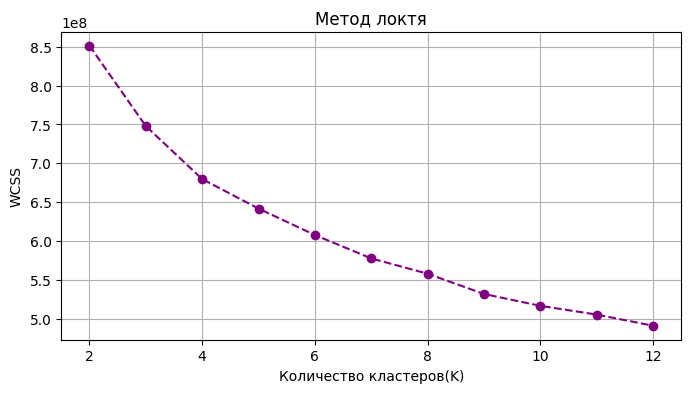

In [49]:
%%time
inertia = [] 
max_clusters = 12 # Максимальное количество кластеров
for i in tqdm(range(2, max_clusters + 1)):
    kmeans = KMeans(n_clusters=i, random_state=2023) 
    kmeans.fit(count_matrix)
    inertia.append(kmeans.inertia_)

# Визуализируем 
plt.figure(figsize=(8, 4))
plt.plot(range(2, max_clusters + 1), inertia, marker='o', linestyle='--', color='purple')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров(K)')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [60]:
k = 10 # Выберем наилучшее количество классов
kmeans = KMeans(n_clusters=k, random_state=0) 
clusters = kmeans.fit_predict(count_matrix) # Получим класстер для каждой итерации

df['CLASS'] = clusters # Занесём в отдельный признак
df['CLASS'].value_counts() / df.shape[0] * 100 # Отобразим процентное соотношение 

CLASS
4    98.128679
0     1.590728
2     0.155416
5     0.092124
7     0.014065
3     0.010549
1     0.004923
6     0.002110
9     0.000703
8     0.000703
Name: count, dtype: float64

In [63]:
%%time
from sklearn.cluster import DBSCAN
dbscan = DBSCAN()
dbscan.fit(count_matrix)
dbscan.labels_

CPU times: total: 11min 31s
Wall time: 13min 8s


array([ -1,  -1,  -1, ...,  -1, 344,  -1], dtype=int64)

In [64]:
len(set(dbscan.labels_))

363

In [65]:
df['CLASS'] = dbscan.labels_ # Занесём в отдельный признак
df['CLASS'].value_counts() / df.shape[0] * 100 # Отобразим процентное соотношение 

CLASS
-1      95.320642
 182     0.198314
 176     0.159635
 180     0.132912
 121     0.130803
          ...    
 157     0.003516
 286     0.003516
 163     0.003516
 164     0.003516
 3       0.003516
Name: count, Length: 363, dtype: float64

In [68]:
from sklearn.manifold import TSNE
tsne_model = TSNE(learning_rate=100)
transformed = tsne_model.fit_transform(count_matrix)
len(set(transformed))

TypeError: PCA initialization is currently not supported with the sparse input matrix. Use init="random" instead.

# 2.1 Построение модели классификации

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    count_matrix, df['CLASS'], test_size=0.2, random_state=42)

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
models = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC()
]

In [72]:
from sklearn.metrics import accuracy_score, mean_squared_error
best_model = None # Лучшая модель
best_score = None # Точность у лучшей модели
best_loss = None # Ошибка у лучшей модели
for clf in models:
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)

    # Высчитываем метрики
    r2 = accuracy_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"{clf.__class__.__name__:30}: Score: {r2:17}, RMSE: {round(rmse, 6):10}")

    # Проверям на лучшую модель
    if best_loss != None:
        if best_loss > rmse:
            best_model = clf
            best_score = r2
            best_loss = rmse
    else:
        best_model = clf
        best_score = r2
        best_loss = rmse

# Выводим лучшую модель
print("-"*92)
print(f"{best_model.__class__.__name__:30}: Score: {best_score}, RMSE: {round(best_loss, 6):10}")

LogisticRegression            : Score: 0.9806610407876231, RMSE:  27.118794
KNeighborsClassifier          : Score: 0.9615682137834036, RMSE:  34.126023
SVC                           : Score: 0.9520042194092827, RMSE:  44.586664
--------------------------------------------------------------------------------------------
LogisticRegression            : Score: 0.9806610407876231, RMSE:  27.118794
